# Imports

##### General imports

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

##### Import from flatland environment 

In [3]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator,sparse_rail_generator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator, sparse_schedule_generator
from flatland.utils.rendertools import RenderTool, AgentRenderVariant

##### Import from our framework

In [4]:
from src.graph import NetworkGraph

In [5]:
from src.flows import *

# Test of time expanded network

##### Create a flatland network

sparse netwrok

In [ ]:
number_agents = 5

size_side = 40
stochastic_data = {'prop_malfunction': 0.3,  # Percentage of defective agents
                   'malfunction_rate': 30,  # Rate of malfunction occurence
                   'min_duration': 3,  # Minimal duration of malfunction
                   'max_duration': 20  # Max duration of malfunction
                   }
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train
env = RailEnv(width=size_side,
              height=size_side,
              rail_generator=sparse_rail_generator(max_num_cities=4,
                                                   # Number of cities in map (where train stations are)
                                                   seed=14,  # Random seed
                                                   grid_mode=False,
                                                   max_rails_between_cities=2,
                                                   max_rails_in_city=8,
                                                   ),
              schedule_generator=sparse_schedule_generator(speed_ration_map),
              number_of_agents=number_agents,
              stochastic_data=stochastic_data,  # Malfunction data generator
              obs_builder_object=GlobalObsForRailEnv(),
              remove_agents_at_target=True
              )

# RailEnv.DEPOT_POSITION = lambda agent, agent_handle : (agent_handle % env.height,0)
env.reset()

env_renderer = RenderTool(env,
                          agent_render_variant=AgentRenderVariant.AGENT_SHOWS_OPTIONS_AND_BOX,
                          show_debug=True,
                          screen_height=1100,
                          screen_width=1800)
env_renderer.reset()

env_renderer.render_env(show=True, show_observations=False, show_predictions=False)



usual network

In [6]:
number_agents = 40

size_side = 50
env = RailEnv(width=size_side,
              height=size_side,
              rail_generator=complex_rail_generator(nr_start_goal=number_agents, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, 
                                                    seed = np.random.randint(0,2000)),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_agents,
              obs_builder_object=GlobalObsForRailEnv())

env.reset()



env_renderer = RenderTool(env)
env_renderer.render_env(show=True, show_predictions=False, show_observations=False)

In [7]:
matrix_rail = np.array(env.rail.grid.tolist())
flatlandNetwork = NetworkGraph(matrix_rail,[(0,1)],[(1,0)])

In [8]:
sources = []
sinks = []
directions = []
for agent in env.agents:
    sources.append(agent.initial_position)
    sinks.append(agent.target)
    try:
        directions.append(agent.direction)
    except:
        pass

In [9]:
if len(directions) == 0:
    directions = None

##### create a time expanded network

In [10]:
import time

In [11]:
start = time.time()
TestNetworkTime = TimeNetwork(flatlandNetwork, depth=200)
stop = time.time()
print(f'time taken to build the graph: {stop-start}')

time taken to build the graph: 35.50095820426941


In [12]:
TestNetworkTime.connect_sources_and_sink(sources,sinks,directions = None)

### create initial solution

In [13]:
constraints = TestNetworkTime.get_topology_network()

In [14]:
find_constraints = {}

In [15]:
for restriction in constraints:
    for edge in restriction:
        if edge not in find_constraints.keys():
            find_constraints[edge] = [restriction]
        else:
            find_constraints[edge].append(restriction)

In [28]:
test = InitialSolutionGenerator(TestNetworkTime,constraints,find_constraints,len(sources))

In [29]:
solution = test.getInitialSolution()


0it [00:00, ?it/s]
1it [00:01,  1.49s/it]
2it [00:02,  1.49s/it]
3it [00:13,  4.20s/it]
4it [00:14,  3.34s/it]
5it [00:20,  4.16s/it]
6it [00:25,  4.14s/it]
7it [00:35,  6.00s/it]
8it [00:41,  6.05s/it]
9it [00:50,  7.05s/it]
10it [00:53,  5.59s/it]
11it [00:55,  4.53s/it]
12it [01:03,  5.65s/it]
13it [01:07,  5.20s/it]
14it [01:11,  4.89s/it]
15it [01:13,  3.85s/it]
16it [01:36,  9.55s/it]
17it [01:37,  7.09s/it]
18it [01:41,  6.18s/it]
19it [01:45,  5.63s/it]
20it [01:47,  4.41s/it]
21it [01:48,  3.47s/it]
22it [01:50,  3.00s/it]
23it [01:52,  2.66s/it]
24it [01:55,  2.95s/it]
25it [01:58,  2.79s/it]
26it [02:01,  2.80s/it]
27it [02:18,  7.13s/it]
28it [02:20,  5.49s/it]
29it [02:21,  4.28s/it]
30it [02:28,  5.09s/it]
31it [02:37,  6.11s/it]
32it [02:38,  4.80s/it]
33it [02:43,  4.77s/it]
34it [03:00,  8.53s/it]
35it [03:15, 10.32s/it]
36it [03:20,  8.67s/it]
37it [03:21,  6.49s/it]
38it [03:23,  5.24s/it]
39it [03:27,  4.72s/it]
40it [03:44,  5.62s/it]


In [32]:
test.showStats()

{'not shortest path ': 94,
 'time for checkCollision: ': nan,
 'time for pathFinder: ': nan}


In [34]:
solution

[[('source_0', '(6, 23)_S_out_t0'),
  ('(6, 23)_S_out_t0', '(7, 23)_N_in_t1'),
  ('(7, 23)_N_in_t1', '(7, 23)_S_out_t2'),
  ('(7, 23)_S_out_t2', '(8, 23)_N_in_t3'),
  ('(8, 23)_N_in_t3', '(8, 23)_S_out_t4'),
  ('(8, 23)_S_out_t4', '(9, 23)_N_in_t5'),
  ('(9, 23)_N_in_t5', '(9, 23)_S_out_t6'),
  ('(9, 23)_S_out_t6', '(10, 23)_N_in_t7'),
  ('(10, 23)_N_in_t7', '(10, 23)_S_out_t8'),
  ('(10, 23)_S_out_t8', '(11, 23)_N_in_t9'),
  ('(11, 23)_N_in_t9', '(11, 23)_S_out_t10'),
  ('(11, 23)_S_out_t10', '(12, 23)_N_in_t11'),
  ('(12, 23)_N_in_t11', '(12, 23)_S_out_t12'),
  ('(12, 23)_S_out_t12', '(13, 23)_N_in_t13'),
  ('(13, 23)_N_in_t13', '(13, 23)_S_out_t14'),
  ('(13, 23)_S_out_t14', '(14, 23)_N_in_t15'),
  ('(14, 23)_N_in_t15', '(14, 23)_S_out_t16'),
  ('(14, 23)_S_out_t16', '(15, 23)_N_in_t17'),
  ('(15, 23)_N_in_t17', '(15, 23)_S_out_t18'),
  ('(15, 23)_S_out_t18', '(16, 23)_N_in_t19'),
  ('(16, 23)_N_in_t19', '(16, 23)_S_out_t20'),
  ('(16, 23)_S_out_t20', '(17, 23)_N_in_t21'),
  ('(17, 

In [33]:
len(solution) == len(sources)

True

In [39]:
solutions = {}
for i,sol in enumerate(solution):
    solutions[i] = sol[1:-2]

##### Test LP Formulation

test a simple graph

In [ ]:
import datetime as dt
print(dt.datetime.now())

In [ ]:
mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.get_topology_network(),integer = False)

In [ ]:
mcflow.solve()

In [ ]:
paths = mcflow.get_paths_solution()

In [ ]:
score = 0
for _,path in paths.items():
    score += int(len(path)/2)
    
print(f"score {score}")

In [ ]:
lengths = []
pathsToAllongate = copy.deepcopy(mcflow.solution)
for agent,path in pathsToAllongate.items():
    lengths.append(len(path))
    
maxLength = max(lengths)
for agent,path in pathsToAllongate.items():
    for i in range(maxLength-len(path)):
        path.append(None)
    pathsToAllongate[agent] = path

In [ ]:
dfPaths = pd.DataFrame(pathsToAllongate)
dfPaths

In [ ]:
import datetime as dt
print(dt.datetime.now())

In [ ]:
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 190),
          (0, 128, 128), (230, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0), (170, 255, 195),
          (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128), (255, 255, 255), (0, 0, 0)]
colors = [(x[0]/255.,x[1]/255.,x[2]/255.) for x in colors]

IndexError: list index out of range

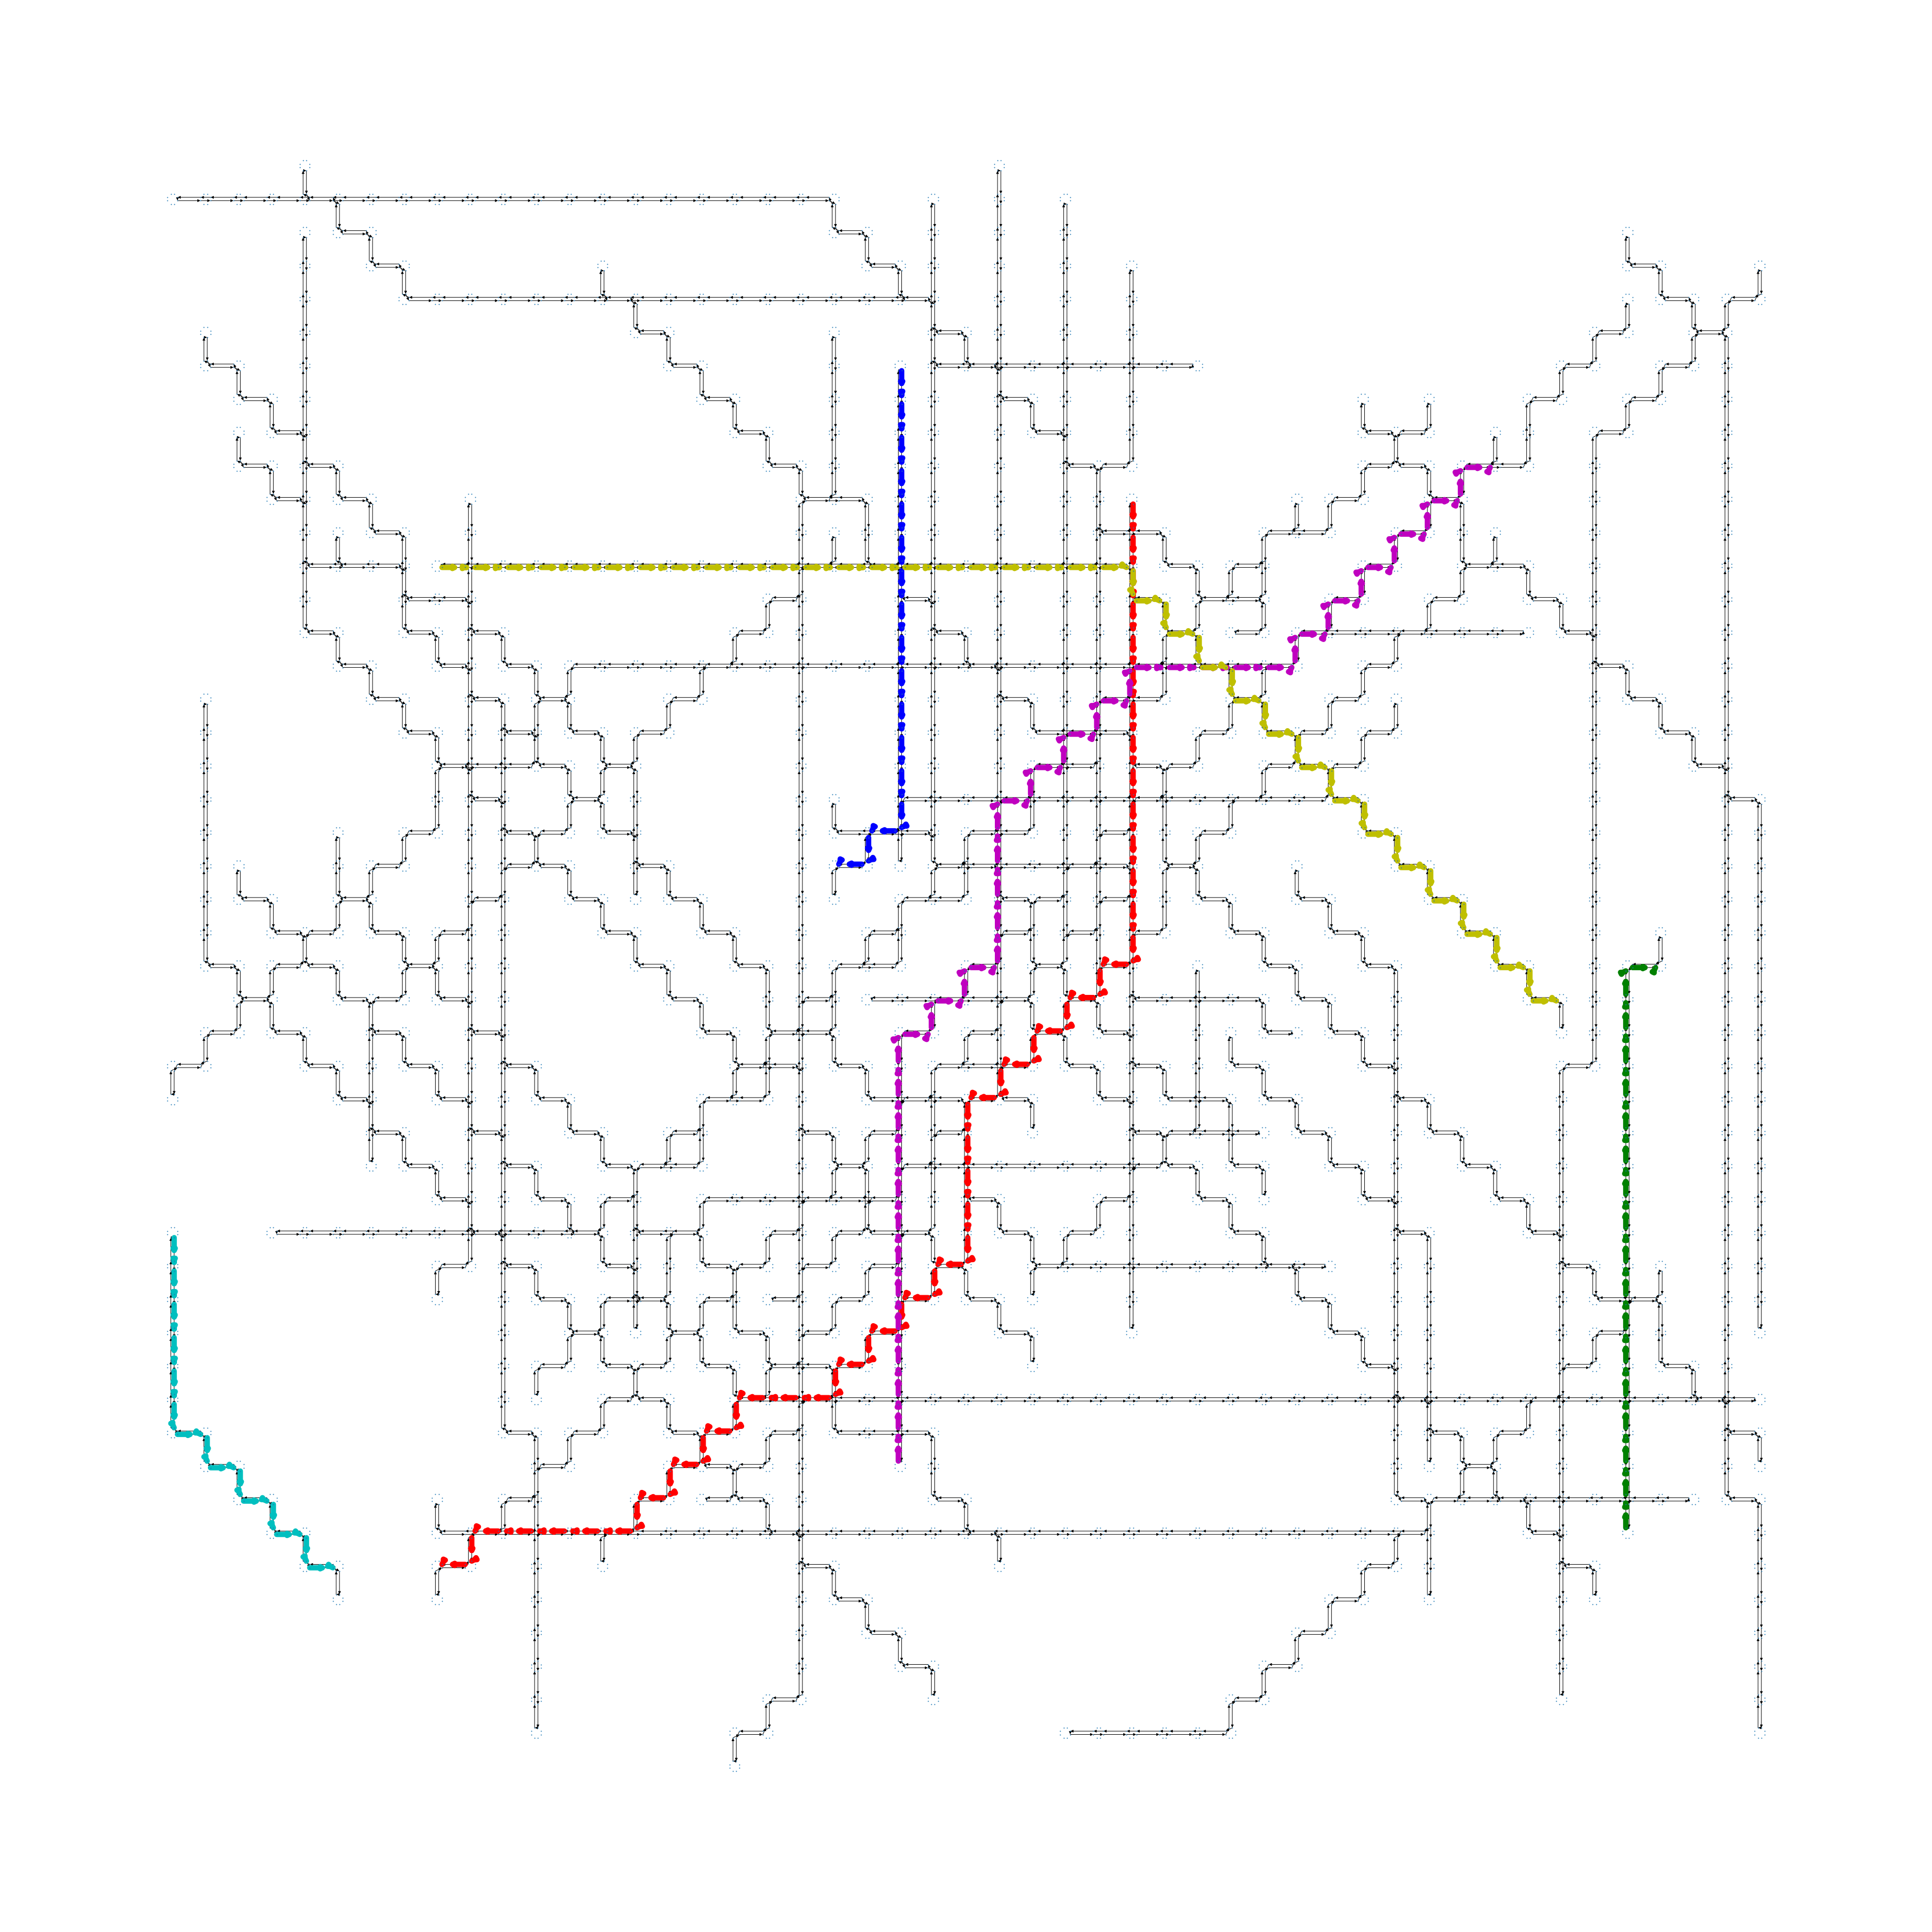

In [40]:
flatlandNetwork.show(paths = solutions)